In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [2]:
# Implement from scratch the following normalization schemes. They should
# be implemented as a sub-class of torch.nn.Module.

# (a) Batch Normalization (BN) [3]
# (b) Instance Normalization (IN) [7]
# (c) Batch-Instance Normalization (BIN) [4]
# (d) Layer Normalization (LN) [1]
# (e) Group Normalization (GN) [8]

import torch
import torch.nn as nn

class NoNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(NoNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return x

class BatchNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        # shape = (1, num_features, 1, 1)
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class InstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(InstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

  

class BatchInstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, k=0.5):
        super(BatchInstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.k = k
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        # shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean_batchnorm = x.mean(dim=[0, 2, 3])
            variance_batchnorm = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean_batchnorm
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance_batchnorm
        else:
            mean_batchnorm = self.running_mean
            variance_batchnorm = self.running_var

        x_batchnorm = (x - mean_batchnorm.view(1, -1, 1, 1)) / (variance_batchnorm.view(1, -1, 1, 1) + self.eps).sqrt()
        mean_instnorm = x.mean(dim=[2, 3], keepdim=True)
        variance_instnorm = x.var(dim=[2, 3], keepdim=True)
        x_instnorm = (x - mean_instnorm) / (variance_instnorm + self.eps).sqrt()

        x = self.k * x_batchnorm + (1 - self.k) * x_instnorm
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

class LayerNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(LayerNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class GroupNormalise(nn.Module):
    def __init__(self, num_features, num_groups=4, eps=1e-5, momentum=0.1):
        super(GroupNormalise, self).__init__()
        self.num_features = num_features
        self.num_groups = num_groups
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.num_groups, int(C / self.num_groups), H, W)
        mean = x.mean(dim=[1, 2, 3], keepdim=True)
        variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = x.view(N, C, H, W)
        x = self.gamma * x + self.beta
        return x



In [3]:
def norms(dimension, norm_type):
    if norm_type == 'none':
        return NoNormalise(dimension)
    elif norm_type == 'batch':
        return BatchNormalise(dimension)
    elif norm_type == 'instance':
        return InstanceNormalise(dimension)
    elif norm_type == 'batchinstance':
        return BatchInstanceNormalise(dimension)
    elif norm_type == 'layer':
        return LayerNormalise(dimension)
    elif norm_type == 'group':
        return GroupNormalise(dimension)
    else:
        raise ValueError('Invalid norm type')
    

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1, norm_type='none'):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = norms(out_chs, norm_type)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = norms(out_chs, norm_type)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    

class resnet(nn.Module): # n layers of blocks, r classes
    def __init__(self, resd_block, layers, img_chs, r, norm_type):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = norms(16, norm_type)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1, norm_type)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2, norm_type)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2, norm_type)
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride, norm_type):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), norms(out_chs, norm_type))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride, norm_type))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs, norm_type=norm_type))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

def final_resnet(img_chs, r, n, norm_type):
    return resnet(resd_block, [n, n, n], img_chs, r, norm_type)

In [4]:
# The hyperparameters

n = 2
r = 25
batch_size = 32
# learning_rate = 0.0001
num_epochs = 50 
num_workers = 4
norm_type = 'batchinstance'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Device: ", device)

Device:  cuda:0


Train Data:  29417
Validation Data:  8413
------------------------Training Started------------------------


100%|██████████| 263/263 [00:27<00:00,  9.70it/s]


Epoch:  0 Train Loss:  0.09000738196245417 Train Accuracy:  13.947717306319477 Train F1 Macro:  0.1203920828054141 Train F1 Micro:  0.13947717306319476
Epoch:  0 Validation Loss:  0.08222686681880065 Validation Accuracy:  20.40889100202068 Validation F1 Macro:  0.1718422964963212 Validation F1 Micro:  0.20408891002020682
---------------------------------------------------------------


100%|██████████| 263/263 [00:26<00:00,  9.76it/s]


Epoch:  1 Train Loss:  0.07910718345486478 Train Accuracy:  22.619573715878573 Train F1 Macro:  0.20147982032066583 Train F1 Micro:  0.22619573715878574
Epoch:  1 Validation Loss:  0.0749665791053459 Validation Accuracy:  26.38773326993938 Validation F1 Macro:  0.23125669493145498 Validation F1 Micro:  0.2638773326993938
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.72it/s]


Epoch:  2 Train Loss:  0.07276400084174109 Train Accuracy:  28.986640378012712 Train F1 Macro:  0.26730588416528006 Train F1 Micro:  0.2898664037801271
Epoch:  2 Validation Loss:  0.06959939681717095 Validation Accuracy:  32.14073457743968 Validation F1 Macro:  0.29605204689493936 Validation F1 Micro:  0.3214073457743968
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.69it/s]


Epoch:  3 Train Loss:  0.0662373901933161 Train Accuracy:  36.18315939762722 Train F1 Macro:  0.34599843925240414 Train F1 Micro:  0.36183159397627224
Epoch:  3 Validation Loss:  0.062254252330905174 Validation Accuracy:  40.55628194460954 Validation F1 Macro:  0.3923930032087572 Validation F1 Micro:  0.40556281944609535
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.67it/s]


Epoch:  4 Train Loss:  0.06039173047798765 Train Accuracy:  41.700377332834755 Train F1 Macro:  0.4053706945821867 Train F1 Micro:  0.41700377332834754
Epoch:  4 Validation Loss:  0.05634676745569013 Validation Accuracy:  45.47723760846309 Validation F1 Macro:  0.44249909780862784 Validation F1 Micro:  0.45477237608463095
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.64it/s]


Epoch:  5 Train Loss:  0.05550906598359264 Train Accuracy:  46.167182241561 Train F1 Macro:  0.4528628140483304 Train F1 Micro:  0.46167182241561
Epoch:  5 Validation Loss:  0.051810386403908025 Validation Accuracy:  50.12480684654701 Validation F1 Macro:  0.48597968993764923 Validation F1 Micro:  0.5012480684654701
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.67it/s]


Epoch:  6 Train Loss:  0.05142820692323352 Train Accuracy:  50.14787367848523 Train F1 Macro:  0.49460819378371357 Train F1 Micro:  0.5014787367848523
Epoch:  6 Validation Loss:  0.04761073496655421 Validation Accuracy:  53.84523951028171 Validation F1 Macro:  0.53321392277607 Validation F1 Micro:  0.5384523951028171
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.57it/s]


Epoch:  7 Train Loss:  0.04811662239598341 Train Accuracy:  53.224326069959545 Train F1 Macro:  0.52668868829361 Train F1 Micro:  0.5322432606995955
Epoch:  7 Validation Loss:  0.04685075628010736 Validation Accuracy:  53.09639843099965 Validation F1 Macro:  0.5228855302664328 Validation F1 Micro:  0.5309639843099965
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.60it/s]


Epoch:  8 Train Loss:  0.04508183328446539 Train Accuracy:  56.916068939728724 Train F1 Macro:  0.5654134154094309 Train F1 Micro:  0.5691606893972873
Epoch:  8 Validation Loss:  0.043602812168686875 Validation Accuracy:  57.090217520503984 Validation F1 Macro:  0.5646164338123983 Validation F1 Micro:  0.5709021752050398
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.54it/s]


Epoch:  9 Train Loss:  0.04272252593564198 Train Accuracy:  58.69395247645919 Train F1 Macro:  0.5838359160547705 Train F1 Micro:  0.5869395247645919
Epoch:  9 Validation Loss:  0.04170999350884178 Validation Accuracy:  59.81219541186259 Validation F1 Macro:  0.58631125805965 Validation F1 Micro:  0.5981219541186259
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.62it/s]


Epoch:  10 Train Loss:  0.04064561567206992 Train Accuracy:  61.11092225583846 Train F1 Macro:  0.6085646295871081 Train F1 Micro:  0.6111092225583846
Epoch:  10 Validation Loss:  0.04064638376356404 Validation Accuracy:  60.39462736241531 Validation F1 Macro:  0.6059257603838928 Validation F1 Micro:  0.6039462736241531
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.57it/s]


Epoch:  11 Train Loss:  0.03865846895598561 Train Accuracy:  62.95339429581534 Train F1 Macro:  0.6272719382251725 Train F1 Micro:  0.6295339429581535
Epoch:  11 Validation Loss:  0.037444108677125776 Validation Accuracy:  64.4478782836087 Validation F1 Macro:  0.6433060286901958 Validation F1 Micro:  0.6444787828360871
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.58it/s]


Epoch:  12 Train Loss:  0.0371026247299094 Train Accuracy:  64.41853350103682 Train F1 Macro:  0.6426681762739296 Train F1 Micro:  0.6441853350103681
Epoch:  12 Validation Loss:  0.03549673570158166 Validation Accuracy:  65.6959467490788 Validation F1 Macro:  0.6542733723095203 Validation F1 Micro:  0.656959467490788
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.54it/s]


Epoch:  13 Train Loss:  0.03570244703099304 Train Accuracy:  65.18679675017847 Train F1 Macro:  0.6507540057880277 Train F1 Micro:  0.6518679675017847
Epoch:  13 Validation Loss:  0.03676923101996605 Validation Accuracy:  62.7481278973018 Validation F1 Macro:  0.6302347815096829 Validation F1 Micro:  0.627481278973018
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.57it/s]


Epoch:  14 Train Loss:  0.03446697944219729 Train Accuracy:  67.09725668830949 Train F1 Macro:  0.6702821709420708 Train F1 Micro:  0.6709725668830948
Epoch:  14 Validation Loss:  0.03421748146940805 Validation Accuracy:  66.93212884821111 Validation F1 Macro:  0.670996130238493 Validation F1 Micro:  0.669321288482111
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.56it/s]


Epoch:  15 Train Loss:  0.033434209290070134 Train Accuracy:  67.85872114763572 Train F1 Macro:  0.6782398547176876 Train F1 Micro:  0.6785872114763573
Epoch:  15 Validation Loss:  0.03157821717244414 Validation Accuracy:  69.38072031380007 Validation F1 Macro:  0.6923861719591139 Validation F1 Micro:  0.6938072031380007
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.56it/s]


Epoch:  16 Train Loss:  0.03230129184820806 Train Accuracy:  68.72556684910086 Train F1 Macro:  0.6869295876802696 Train F1 Micro:  0.6872556684910086
Epoch:  16 Validation Loss:  0.031130934353533927 Validation Accuracy:  70.26031142279805 Validation F1 Macro:  0.7037686114788514 Validation F1 Micro:  0.7026031142279805
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.57it/s]


Epoch:  17 Train Loss:  0.03142892083446737 Train Accuracy:  69.71479076724343 Train F1 Macro:  0.6970255501408755 Train F1 Micro:  0.6971479076724343
Epoch:  17 Validation Loss:  0.029446382556873568 Validation Accuracy:  71.75799358136217 Validation F1 Macro:  0.7151575822922079 Validation F1 Micro:  0.7175799358136217
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.53it/s]


Epoch:  18 Train Loss:  0.030681115697054843 Train Accuracy:  70.53404494000068 Train F1 Macro:  0.7052962065524001 Train F1 Micro:  0.7053404494000068
Epoch:  18 Validation Loss:  0.02919670799431613 Validation Accuracy:  71.48460715559254 Validation F1 Macro:  0.7149116943484262 Validation F1 Micro:  0.7148460715559254
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.50it/s]


Epoch:  19 Train Loss:  0.029815444343049613 Train Accuracy:  71.13233844375702 Train F1 Macro:  0.7116445982023965 Train F1 Micro:  0.7113233844375701
Epoch:  19 Validation Loss:  0.0290668597193602 Validation Accuracy:  71.9006299774159 Validation F1 Macro:  0.7164488004018712 Validation F1 Micro:  0.7190062997741591
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.53it/s]


Epoch:  20 Train Loss:  0.028999495028914548 Train Accuracy:  71.95159261651426 Train F1 Macro:  0.7196629097735264 Train F1 Micro:  0.7195159261651426
Epoch:  20 Validation Loss:  0.028872167383619852 Validation Accuracy:  71.9006299774159 Validation F1 Macro:  0.7205971432056743 Validation F1 Micro:  0.7190062997741591
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.51it/s]


Epoch:  21 Train Loss:  0.028306916340383702 Train Accuracy:  72.67906312676344 Train F1 Macro:  0.7271993504694982 Train F1 Micro:  0.7267906312676344
Epoch:  21 Validation Loss:  0.027472349837321414 Validation Accuracy:  73.32699393795316 Validation F1 Macro:  0.7310982597754436 Validation F1 Micro:  0.7332699393795317
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.49it/s]


Epoch:  22 Train Loss:  0.0274825341644693 Train Accuracy:  73.63089370092123 Train F1 Macro:  0.736666969419983 Train F1 Micro:  0.7363089370092124
Epoch:  22 Validation Loss:  0.028569683028743933 Validation Accuracy:  72.05515273980744 Validation F1 Macro:  0.7255079804470214 Validation F1 Micro:  0.7205515273980744
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.46it/s]


Epoch:  23 Train Loss:  0.02693720129748944 Train Accuracy:  74.04222048475371 Train F1 Macro:  0.7409123028210154 Train F1 Micro:  0.7404222048475373
Epoch:  23 Validation Loss:  0.02602623920796049 Validation Accuracy:  74.87222156186853 Validation F1 Macro:  0.7505957768247682 Validation F1 Micro:  0.7487222156186853
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.48it/s]


Epoch:  24 Train Loss:  0.026475148389911402 Train Accuracy:  74.68810551721793 Train F1 Macro:  0.7476148104710435 Train F1 Micro:  0.7468810551721793
Epoch:  24 Validation Loss:  0.02521085062269137 Validation Accuracy:  75.75181267086651 Validation F1 Macro:  0.7588569963070826 Validation F1 Micro:  0.7575181267086651
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.53it/s]


Epoch:  25 Train Loss:  0.025800218833847543 Train Accuracy:  75.10623109086583 Train F1 Macro:  0.7517780083791721 Train F1 Micro:  0.7510623109086583
Epoch:  25 Validation Loss:  0.02575071649748775 Validation Accuracy:  75.2882443836919 Validation F1 Macro:  0.7534572777647164 Validation F1 Micro:  0.752882443836919
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.47it/s]


Epoch:  26 Train Loss:  0.02542044523903696 Train Accuracy:  75.65353367100656 Train F1 Macro:  0.7572357876997353 Train F1 Micro:  0.7565353367100655
Epoch:  26 Validation Loss:  0.02485043341270684 Validation Accuracy:  75.57351717579935 Validation F1 Macro:  0.753064834983534 Validation F1 Micro:  0.7557351717579935
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.47it/s]


Epoch:  27 Train Loss:  0.02482415343297834 Train Accuracy:  76.13964714280857 Train F1 Macro:  0.762007432500086 Train F1 Micro:  0.7613964714280856
Epoch:  27 Validation Loss:  0.024297457735227884 Validation Accuracy:  76.39367645310828 Validation F1 Macro:  0.7618701998242553 Validation F1 Micro:  0.7639367645310828
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.45it/s]


Epoch:  28 Train Loss:  0.02430889839346681 Train Accuracy:  76.89771220722712 Train F1 Macro:  0.7697059259986768 Train F1 Micro:  0.7689771220722711
Epoch:  28 Validation Loss:  0.02357847297037879 Validation Accuracy:  77.33269939379531 Validation F1 Macro:  0.7762361983757543 Validation F1 Micro:  0.7733269939379531
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.44it/s]


Epoch:  29 Train Loss:  0.023944435125059116 Train Accuracy:  77.19685895910527 Train F1 Macro:  0.7727741129612178 Train F1 Micro:  0.7719685895910526
Epoch:  29 Validation Loss:  0.02428089189044817 Validation Accuracy:  76.91667657197195 Validation F1 Macro:  0.7708432590455575 Validation F1 Micro:  0.7691667657197195
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.45it/s]


Epoch:  30 Train Loss:  0.023451902799742158 Train Accuracy:  77.4722099466295 Train F1 Macro:  0.7753786925188945 Train F1 Micro:  0.7747220994662949
Epoch:  30 Validation Loss:  0.022348053429245198 Validation Accuracy:  78.64019969095447 Validation F1 Macro:  0.7869917861245015 Validation F1 Micro:  0.7864019969095447
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.44it/s]


Epoch:  31 Train Loss:  0.02311038007490469 Train Accuracy:  78.01611313186253 Train F1 Macro:  0.7810272836209523 Train F1 Micro:  0.7801611313186253
Epoch:  31 Validation Loss:  0.021937473952189278 Validation Accuracy:  79.17508617615596 Validation F1 Macro:  0.7936868516527555 Validation F1 Micro:  0.7917508617615595
---------------------------------------------------------------


100%|██████████| 263/263 [00:27<00:00,  9.43it/s]


Epoch:  32 Train Loss:  0.022679979064371608 Train Accuracy:  78.50902539347996 Train F1 Macro:  0.7858489569427117 Train F1 Micro:  0.7850902539347996
Epoch:  32 Validation Loss:  0.021478798439241144 Validation Accuracy:  79.674313562344 Validation F1 Macro:  0.7987903371170034 Validation F1 Micro:  0.7967431356234399
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.38it/s]


Epoch:  33 Train Loss:  0.02242518412887343 Train Accuracy:  78.7367848522963 Train F1 Macro:  0.7881481745303283 Train F1 Micro:  0.7873678485229629
Epoch:  33 Validation Loss:  0.021210216055737655 Validation Accuracy:  79.6980862950196 Validation F1 Macro:  0.7960368267075245 Validation F1 Micro:  0.7969808629501961
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.36it/s]


Epoch:  34 Train Loss:  0.021912674502561 Train Accuracy:  79.07672434306693 Train F1 Macro:  0.7916135211939297 Train F1 Micro:  0.7907672434306693
Epoch:  34 Validation Loss:  0.021302333263031412 Validation Accuracy:  79.80506359205991 Validation F1 Macro:  0.7974679589521143 Validation F1 Micro:  0.7980506359205991
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.35it/s]


Epoch:  35 Train Loss:  0.02163882019218551 Train Accuracy:  79.24329469354456 Train F1 Macro:  0.7932759478493199 Train F1 Micro:  0.7924329469354455
Epoch:  35 Validation Loss:  0.021557843884056647 Validation Accuracy:  78.8898133840485 Validation F1 Macro:  0.7903569813860749 Validation F1 Micro:  0.7888981338404851
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.38it/s]


Epoch:  36 Train Loss:  0.021381275319496303 Train Accuracy:  79.49824931162253 Train F1 Macro:  0.795650029409872 Train F1 Micro:  0.7949824931162253
Epoch:  36 Validation Loss:  0.020841323842648644 Validation Accuracy:  79.88826815642457 Validation F1 Macro:  0.7991323508825054 Validation F1 Micro:  0.7988826815642458
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.32it/s]


Epoch:  37 Train Loss:  0.021195799994728853 Train Accuracy:  79.94696943943977 Train F1 Macro:  0.8002718361199221 Train F1 Micro:  0.7994696943943977
Epoch:  37 Validation Loss:  0.02069651783061739 Validation Accuracy:  80.18542731486984 Validation F1 Macro:  0.8014155754596828 Validation F1 Micro:  0.8018542731486984
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.33it/s]


Epoch:  38 Train Loss:  0.020892266423056208 Train Accuracy:  80.2733113505796 Train F1 Macro:  0.80352220435988 Train F1 Micro:  0.802733113505796
Epoch:  38 Validation Loss:  0.019646838281698182 Validation Accuracy:  81.17199572090811 Validation F1 Macro:  0.8113672414694305 Validation F1 Micro:  0.8117199572090812
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.36it/s]


Epoch:  39 Train Loss:  0.02056778397917784 Train Accuracy:  80.15093313390217 Train F1 Macro:  0.8023325922645022 Train F1 Micro:  0.8015093313390217
Epoch:  39 Validation Loss:  0.019785698645395176 Validation Accuracy:  80.88672292880067 Validation F1 Macro:  0.8116328166569369 Validation F1 Micro:  0.8088672292880067
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.30it/s]


Epoch:  40 Train Loss:  0.020400838074355252 Train Accuracy:  80.6982357140429 Train F1 Macro:  0.8079909922365347 Train F1 Micro:  0.806982357140429
Epoch:  40 Validation Loss:  0.019180796420540182 Validation Accuracy:  81.75442767146083 Validation F1 Macro:  0.8197361293062734 Validation F1 Micro:  0.8175442767146083
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.35it/s]


Epoch:  41 Train Loss:  0.020207892558947255 Train Accuracy:  80.72543087330455 Train F1 Macro:  0.8080626713303518 Train F1 Micro:  0.8072543087330456
Epoch:  41 Validation Loss:  0.019845763295552373 Validation Accuracy:  81.23142755259717 Validation F1 Macro:  0.8145851266437971 Validation F1 Micro:  0.8123142755259717
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.30it/s]


Epoch:  42 Train Loss:  0.020002321041501202 Train Accuracy:  81.02457762518272 Train F1 Macro:  0.8111265451363155 Train F1 Micro:  0.8102457762518271
Epoch:  42 Validation Loss:  0.01916332739145963 Validation Accuracy:  82.43195055271603 Validation F1 Macro:  0.824384080708168 Validation F1 Micro:  0.8243195055271604
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.25it/s]


Epoch:  43 Train Loss:  0.01980544020575889 Train Accuracy:  81.39511167012272 Train F1 Macro:  0.8147834230847663 Train F1 Micro:  0.8139511167012272
Epoch:  43 Validation Loss:  0.018899708687834034 Validation Accuracy:  82.11101866159515 Validation F1 Macro:  0.8222007464617193 Validation F1 Micro:  0.8211101866159515
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.29it/s]


Epoch:  44 Train Loss:  0.019753090619623496 Train Accuracy:  81.34752014141483 Train F1 Macro:  0.8141426250982572 Train F1 Micro:  0.8134752014141483
Epoch:  44 Validation Loss:  0.019093926718356025 Validation Accuracy:  81.86140496850113 Validation F1 Macro:  0.8189556939775403 Validation F1 Micro:  0.8186140496850114
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.24it/s]


Epoch:  45 Train Loss:  0.019530751154287165 Train Accuracy:  81.51409049189245 Train F1 Macro:  0.815956762830546 Train F1 Micro:  0.8151409049189244
Epoch:  45 Validation Loss:  0.018718240451181485 Validation Accuracy:  82.51515511708071 Validation F1 Macro:  0.8271600204948828 Validation F1 Micro:  0.8251515511708071
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.23it/s]


Epoch:  46 Train Loss:  0.0193775424251713 Train Accuracy:  81.71465479144713 Train F1 Macro:  0.817761499769971 Train F1 Micro:  0.8171465479144713
Epoch:  46 Validation Loss:  0.018601092663245437 Validation Accuracy:  82.61024604778319 Validation F1 Macro:  0.8284508139623863 Validation F1 Micro:  0.826102460477832
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.29it/s]


Epoch:  47 Train Loss:  0.019306478665866003 Train Accuracy:  81.79963966413978 Train F1 Macro:  0.8189204443059225 Train F1 Micro:  0.8179963966413977
Epoch:  47 Validation Loss:  0.018285218537257626 Validation Accuracy:  82.7409960774991 Validation F1 Macro:  0.827681698682667 Validation F1 Micro:  0.8274099607749911
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.26it/s]


Epoch:  48 Train Loss:  0.01920383015110778 Train Accuracy:  81.81663663867832 Train F1 Macro:  0.8189464365783026 Train F1 Micro:  0.8181663663867833
Epoch:  48 Validation Loss:  0.018212637981506387 Validation Accuracy:  82.58647331510757 Validation F1 Macro:  0.8266182602322516 Validation F1 Micro:  0.8258647331510757
---------------------------------------------------------------


100%|██████████| 263/263 [00:28<00:00,  9.26it/s]


Epoch:  49 Train Loss:  0.019138943125990338 Train Accuracy:  82.01040214841758 Train F1 Macro:  0.8209292944960973 Train F1 Micro:  0.8201040214841759
Epoch:  49 Validation Loss:  0.018344095038996432 Validation Accuracy:  82.7409960774991 Validation F1 Macro:  0.8285076394516895 Validation F1 Micro:  0.8274099607749911
---------------------------------------------------------------


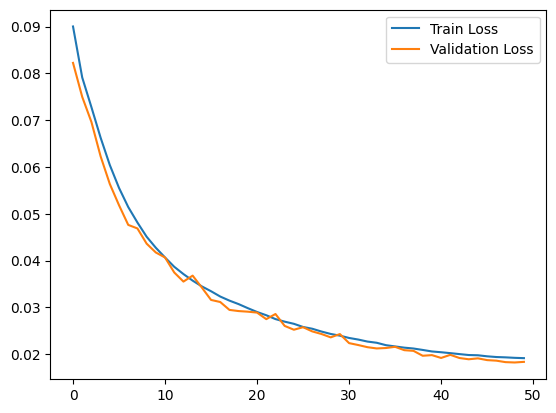

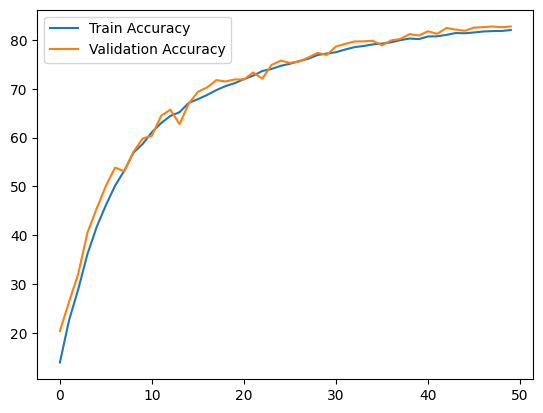

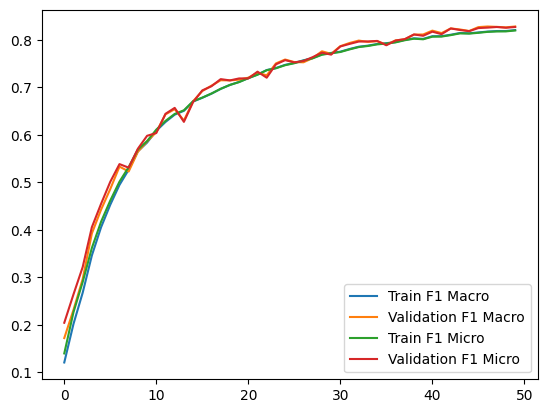

In [5]:
def training():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print("Train Data: ", len(train_dataset))
    print("Validation Data: ", len(val_dataset))

    net = final_resnet(3, r, n, norm_type)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_f1_macro = []
    val_f1_macro = []
    train_f1_micro = []
    val_f1_micro = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)
        train_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        train_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_loss.append(running_loss/total)
        val_accuracy.append((correct/total)*100)
        val_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        val_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Train Accuracy: ", train_accuracy[-1], "Train F1 Macro: ", train_f1_macro[-1], "Train F1 Micro: ", train_f1_micro[-1])

        print("Epoch: ", epoch, "Validation Loss: ", val_loss[-1], "Validation Accuracy: ", val_accuracy[-1], "Validation F1 Macro: ", val_f1_macro[-1], "Validation F1 Micro: ", val_f1_micro[-1])

        print("---------------------------------------------------------------")

        with open('Part2-custom_batchinstancenorm', 'a') as f:
            f.write("Epoch: " + str(epoch) + " Train Loss: " + str(train_loss[-1]) + " Train Accuracy: " + str(train_accuracy[-1]) + " Train F1 Macro: " + str(train_f1_macro[-1]) + " Train F1 Micro: " + str(train_f1_micro[-1]) + "\n")
            f.write("Epoch: " + str(epoch) + " Validation Loss: " + str(val_loss[-1]) + " Validation Accuracy: " + str(val_accuracy[-1]) + " Validation F1 Macro: " + str(val_f1_macro[-1]) + " Validation F1 Micro: " + str(val_f1_micro[-1]) + "\n")
            f.write("---------------------------------------------------------------\n")

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_f1_macro, label='Train F1 Macro')
    plt.plot(val_f1_macro, label='Validation F1 Macro')
    plt.legend()

    plt.plot(train_f1_micro, label='Train F1 Micro')
    plt.plot(val_f1_micro, label='Validation F1 Micro')
    plt.legend()
    plt.show()

    torch.save(net.state_dict(), 'Part2-custom_batchinstancenorm.pth')
    
    
training()